<a href="https://colab.research.google.com/github/rrsguim/PhD_Economics/blob/master/NN4BC/TL_LSTM_1df_unlocked_EUR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

------------------------------------------------------------------------------------------------------
Copyright (c) 2020 Rafael Guimaraes

This work was done when I was at the University of California, Riverside, USA. 

It is part of my doctoral thesis in Economics at the Federal University of 

Rio Grande do Sul, Porto Alegre, Brazil.


See full material at https://github.com/rrsguim/PhD_Economics

The code below, under the Apache License, was inspired by

*Classification on imbalanced data*, and 

*Introduction to the Keras Tuner*

Copyright 2020 The TensorFlow Authors

https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

https://www.tensorflow.org/tutorials/keras/keras_tuner

-------------------------------------------------------------------------

# Transfer Learning for Business Cycle Identification

##Setup

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [ ]:
!pip install -U keras-tuner

     |████████████████████████████████| 71kB 3.5MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp36-none-any.whl size=78937 sha256=9bb5d4073f0c61e8e2d2c9348f3c50bb75bd8357af13d8a40ece27d803cf3e9e
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=356787267837731e747e0ae005e1bb148c80d0ac88b915e609c32cd2bbc0cce5
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
import tensorflow as tf
from tensorflow import keras

import IPython

import kerastuner as kt
from kerastuner import RandomSearch

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Deep Learning | United States

###Data loading and pre-processing

#### Download the data set

##### The Dataset

We use FRED Economic Data, provided by the Federal Reserve Bank of Saint Louis. There are several rows in the CSV file. Each row corresponds to a quarter, and each column describes an attribute. We will use this information to infer whether the US Economy is in recession, which in this dataset is a binary classification task.

Following is a description of this dataset. Notice that there are both numeric and categorical columns. All data refer to United States of America from 1967Q1 to 2019Q4.

>Column| Source| Description| Feature Type | Data Type
>------------|--------------------|----------------------|-----------------|----------------
>GDP | FRED-MD | GDPC1 - Real Gross Domestic Product, s.a. | Numerical | float
>Income | FRED-MD | PIECTR - Real personal income ex current transfer receipts, s.a. | Numerical | float
>Employment | FRED-MD | PRS85006013 - Nonfarm Business Sector employment index, s.a. | Numerical | float
>Industry | FRED-MD | IPB50001SQ - Industrial production index, s.a. | Numerical | float
>Sales | FRED-MD | CQRMTSPL - Real manufacturing and trade industries sales, s.a. | Numerical | float
>Target | FRED-MD | USRECQ - NBER based Recession Indicator (1 = true; 0 = false) | Classification | integer

In [ ]:
file = tf.keras.utils
raw_data = pd.read_csv('https://raw.githubusercontent.com/rrsguim/PhD_Economics/master/TL4BC/TL4BC_US_data.csv')

In [ ]:
raw_data.index = raw_data['DATE']
drop_DATE = raw_data.pop('DATE')
raw_data.index = pd.to_datetime(raw_data.index,infer_datetime_format=True)
raw_data.index = raw_data.index.to_period("Q")

#### Examine the class label imbalance

In [ ]:
neg, pos = np.bincount(raw_data['NBER'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 212
    Positive: 27 (12.74% of total)



#### Transform the features into log first difference.

In [ ]:
log_data = raw_data.copy()

log_data['GDP'] = np.log(log_data['GDP'])
log_data['Income'] = np.log(log_data['Income'])
log_data['Employment'] = np.log(log_data['Employment'])
log_data['Industry'] = np.log(log_data['Industry'])
log_data['Sales'] = np.log(log_data['Sales'])

In [ ]:
log_1df = log_data.copy()

log_1df['GDP'] = log_data['GDP'] - log_data['GDP'].shift(1)
log_1df['Income'] = log_data['Income'] - log_data['Income'].shift(1)
log_1df['Employment'] = log_data['Employment'] - log_data['Employment'].shift(1)
log_1df['Industry'] = log_data['Industry'] - log_data['Industry'].shift(1)
log_1df['Sales'] = log_data['Sales'] - log_data['Sales'].shift(1)

Cut the first line because of NaN in lag features and observe last lines of the adjusted dataset.

In [ ]:
log_1df = log_1df[1:]
log_1df.tail()

,GDP,Income,Employment,Industry,Sales,NBER
DATE,,,,,,
2018Q4,0.002710,0.005645,0.004112,0.009481,0.003436,0
2019Q1,0.007623,0.009776,0.001403,-0.004879,0.014956,0
2019Q2,0.004985,0.004228,0.000904,-0.005700,-0.005293,0
2019Q3,0.005204,0.001736,0.007021,0.002808,0.009172,0
2019Q4,0.005261,0.005844,0.001715,0.000877,0.000543,0


Observe last lines of the adjusted dataset.

#### Inspect pre-processed data

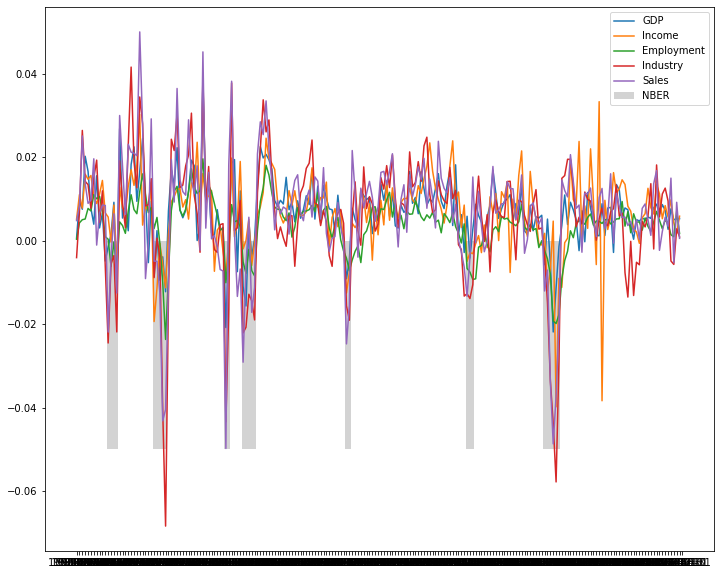

In [ ]:
plt.plot(drop_DATE[1:], log_1df['GDP'], label='GDP')
plt.plot(drop_DATE[1:], log_1df['Income'], label='Income')
plt.plot(drop_DATE[1:], log_1df['Employment'], label='Employment')
plt.plot(drop_DATE[1:], log_1df['Industry'], label='Industry')
plt.plot(drop_DATE[1:], log_1df['Sales'], label='Sales')
plt.bar(drop_DATE, raw_data['NBER']/-20, width=1, linewidth=1, align='center', color="lightgray", label='NBER') 
plt.legend()
plt.show()

#### Split, but no shuffle

Split the dataset into train, validation, and test sets. The validation set is used during the model fitting to evaluate the loss and any metrics, however, the model is not fit with this data. The test set is completely unused during the training phase and is only used at the end to evaluate how well the model generalizes to new data. This is especially important with imbalanced datasets where overfitting is a significant concern from the lack of training data.

In [ ]:
# Use a utility from sklearn to split our dataset.
train_df, test_df = train_test_split(log_1df, test_size=0.4, random_state=0, shuffle=False)  #40% test_size, then we have two recessions on test_set
train_df, val_df = train_test_split(train_df, test_size=0.3, random_state=0, shuffle=False)  

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('NBER'))
#bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('NBER'))
test_labels = np.array(test_df.pop('NBER'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

#### Normalize

Normalize the input features using the sklearn StandardScaler.
This will set the mean to 0 and standard deviation to 1.

Note: The `StandardScaler` is only fit using the `train_features` to be sure the model is not peeking at the validation or test sets. 

In [ ]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


Adjust model input dim because of LSTM

In [ ]:
train_features = np.expand_dims(train_features, 1)
val_features = np.expand_dims(val_features, 1)
test_features = np.expand_dims(test_features, 1)

#### Initial bias

The correct bias to set can be derived from:

$$ p_0 = pos/(pos + neg) = 1/(1+e^{-b_0}) $$
$$ b_0 = -log_e(1/p_0 - 1) $$
$$ b_0 = log_e(pos/neg)$$

Set that as the initial bias, and the model will give much more reasonable initial guesses.

In [ ]:
initial_bias = np.log([pos/neg])

### Define the model and metrics

Define a function that creates a simple neural network with a densly connected hidden layer, a [dropout](https://developers.google.com/machine-learning/glossary/#dropout_regularization) layer to reduce overfitting, and an output sigmoid layer that returns the probability of recession. Also, pick the optimal set of hyperparameters with [Keras Tunner](https://www.tensorflow.org/tutorials/keras/keras_tuner).

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]


def make_model(hp, metrics = METRICS, output_bias = initial_bias):  
  output_bias = tf.keras.initializers.Constant(output_bias)

  model = keras.Sequential()
  #model.add(keras.layers.Flatten(input_shape=(train_features.shape[-1],))) 
  
  # Tune the number of units in the layers
  # Choose an optimal value between 16-256
  hp_units = hp.Int('units', min_value = 16, max_value = 256, step = 16)
  
  model.add(keras.layers.LSTM(units = hp_units, input_shape = (1,train_features.shape[-1],), dropout = 0.3)) #LSTM layer
 
  model.add(keras.layers.Dense(units = hp_units, activation = 'relu')) #Dense layer 1
  model.add(keras.layers.Dense(units = hp_units, activation = 'relu')) #Dense layer 2
  model.add(keras.layers.Dense(units = hp_units, activation = 'relu')) #Dense layer 3
  model.add(keras.layers.Dense(units = hp_units, activation = 'relu')) #Dense layer 4

  model.add(keras.layers.Dropout(0.5)) # To prevent overfiting

  model.add(keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)) # Output layer

  # Tune the learning rate for the optimizer 
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])

  model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss = keras.losses.BinaryCrossentropy(), 
                metrics = metrics)
  
  return model


In [ ]:
tuner = kt.Hyperband(make_model,
                     kt.Objective('val_auc', direction='max'), # Maximizes Area Under the ROC Curve
                     max_epochs = 10,
                     factor = 3,)
                     #project_name = 'TL4BC')

#### Understanding useful metrics

Notice that there are a few metrics defined above that can be computed by the model that will be helpful when evaluating the performance.



*   **False** negatives and **false** positives are samples that were **incorrectly** classified
*   **True** negatives and **true** positives are samples that were **correctly** classified
*   **Accuracy** is the percentage of examples correctly classified
>   $\frac{\text{true samples}}{\text{total samples}}$
*   **Precision** is the percentage of **predicted** positives that were correctly classified
>   $\frac{\text{true positives}}{\text{true positives + false positives}}$
*   **Recall** is the percentage of **actual** positives that were correctly classified
>   $\frac{\text{true positives}}{\text{true positives + false negatives}}$
*   **AUC** refers to the Area Under the Curve of a Receiver Operating Characteristic curve (ROC-AUC). This metric is equal to the probability that a classifier will rank a random positive sample higher than than a random negative sample.


Read more:
*  [True vs. False and Positive vs. Negative](https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative)
*  [Accuracy](https://developers.google.com/machine-learning/crash-course/classification/accuracy)
*   [Precision and Recall](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall)
*   [ROC-AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)

### Train the model

Before running the hyperparameter search, define a callback to clear the training outputs at the end of every training step.

In [ ]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

Run the hyperparameter search. The arguments for the search method are the same as those used for tf.keras.model.fit in addition to the callback above.

In [ ]:
tuner.search(train_features, train_labels,
             epochs=50,
             validation_data=(val_features, val_labels), callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the
layers is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 30 Complete [00h 00m 05s]
val_auc: 1.0

Best val_auc So Far: 1.0000001192092896
Total elapsed time: 00h 02m 30s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the
layers is 224 and the optimal learning rate for the optimizer
is 0.01.



Retrain the model with the optimal hyperparameters from the search.

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
baseline_history = model.fit(train_features, train_labels,
             epochs=50,
             validation_data=(val_features, val_labels))

Epoch 1/50
3/3 [==============================] - 1s 370ms/step - loss: 0.4568 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 108.0000 - fn: 18.0000 - accuracy: 0.8571 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5039 - val_loss: 0.3913 - val_tp: 2.0000 - val_fp: 9.0000 - val_tn: 27.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.7632 - val_precision: 0.1818 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 2/50
3/3 [==============================] - 0s 13ms/step - loss: 0.2049 - tp: 15.0000 - fp: 5.0000 - tn: 67.0000 - fn: 1.0000 - accuracy: 0.9318 - precision: 0.7500 - recall: 0.9375 - auc: 0.9740 - val_loss: 0.0544 - val_tp: 2.0000 - val_fp: 0.0000e+00 - val_tn: 36.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 3/50
3/3 [==============================] - 0s 15ms/step - loss: 0.2590 - tp: 11.0000 - fp: 2.0000 - tn: 70.0000 - fn: 5.0000 - accuracy: 0.9205 - precision: 0.8462 - recall: 0.6875 - auc: 0.9388 - val_loss: 0.08

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 224)               206080    
_________________________________________________________________
dense (Dense)                (None, 224)               50400     
_________________________________________________________________
dense_1 (Dense)              (None, 224)               50400     
_________________________________________________________________
dense_2 (Dense)              (None, 224)               50400     
_________________________________________________________________
dense_3 (Dense)              (None, 224)               50400     
_________________________________________________________________
dropout (Dropout)            (None, 224)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 2

### Results

#### Compare with NBER

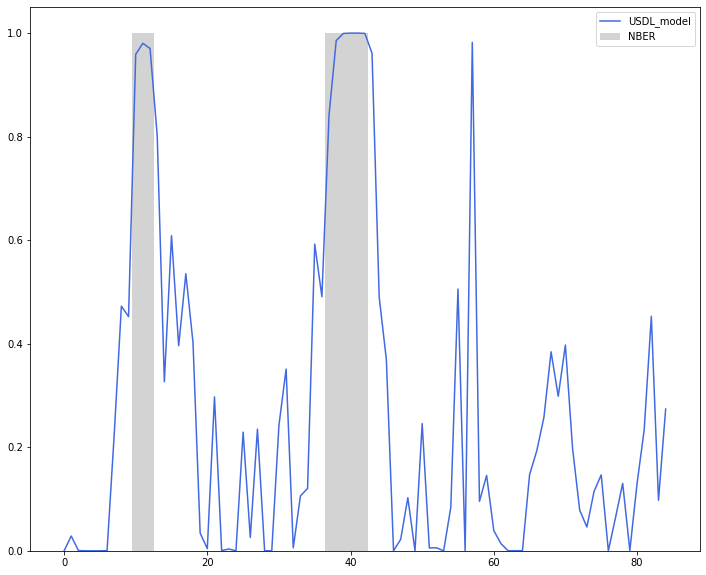

In [ ]:
USDL_model = model.predict(test_features)
time_axis = range(0,test_labels.shape[0])
plt.bar(time_axis, test_labels.T, width=1, linewidth=1, align='center', color="lightgray", label='NBER') 
plt.plot(time_axis, USDL_model, 'b-', color="royalblue", label='USDL_model')
plt.legend()
plt.show()

#### Confusion matrix

We can use a [confusion matrix](https://developers.google.com/machine-learning/glossary/#confusion_matrix) to summarize the actual vs. predicted labels.

In [ ]:
test_predictions_baseline = model.predict(test_features)

In [ ]:
#test_predictions_baseline_2dim = test_predictions_baseline[:, :, 0]

In [ ]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Expansions Detected (True Negatives): ', cm[0][0])
  print('Expansions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Recessions Missed (False Negatives): ', cm[1][0])
  print('Recessions Detected (True Positives): ', cm[1][1])
  print('Total Recessions: ', np.sum(cm[1]))

Evaluate the model on the TEST dataset and display the results for the metrics you created above.

loss :  0.2851439416408539
tp :  9.0
fp :  7.0
tn :  69.0
fn :  0.0
accuracy :  0.9176470637321472
precision :  0.5625
recall :  1.0
auc :  0.9919590950012207

Expansions Detected (True Negatives):  69
Expansions Incorrectly Detected (False Positives):  7
Recessions Missed (False Negatives):  0
Recessions Detected (True Positives):  9
Total Recessions:  9


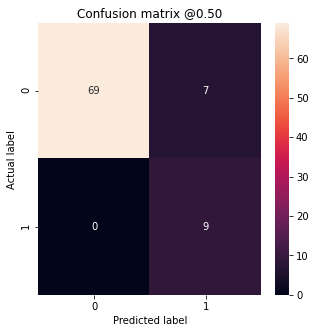

In [ ]:
baseline_results = model.evaluate(test_features, test_labels, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

##Transfer Learning | Brazil

###Euro

In [ ]:
EURO_raw_data = pd.read_csv('https://raw.githubusercontent.com/rrsguim/PhD_Economics/master/NN4BC/TL4BC_Euro_data_2005.csv')

In [ ]:
EURO_raw_data.index = EURO_raw_data['DATE']
drop_DATE = EURO_raw_data.pop('DATE')
EURO_raw_data.index = pd.to_datetime(EURO_raw_data.index,infer_datetime_format=True)
EURO_raw_data.index = EURO_raw_data.index.to_period("Q")

In [ ]:
EURO_log_data = EURO_raw_data.copy()

EURO_log_data['GDP'] = np.log(EURO_log_data['GDP'])
EURO_log_data['Income'] = np.log(EURO_log_data['Income'])
EURO_log_data['Employment'] = np.log(EURO_log_data['Employment'])
EURO_log_data['Industry'] = np.log(EURO_log_data['Industry'])
EURO_log_data['Sales'] = np.log(EURO_log_data['Sales'])

In [ ]:
EURO_log_1df = EURO_log_data.copy()

EURO_log_1df['GDP'] = EURO_log_data['GDP'] - EURO_log_data['GDP'].shift(1)
EURO_log_1df['Income'] = EURO_log_data['Income'] - EURO_log_data['Income'].shift(1)
EURO_log_1df['Employment'] = EURO_log_data['Employment'] - EURO_log_data['Employment'].shift(1)
EURO_log_1df['Industry'] = EURO_log_data['Industry'] - EURO_log_data['Industry'].shift(1)
EURO_log_1df['Sales'] = EURO_log_data['Sales'] - EURO_log_data['Sales'].shift(1)

In [ ]:
EURO_log_1df = EURO_log_1df[1:]
EURO_log_1df.tail()

,GDP,Income,Employment,Industry,Sales,CEPR
DATE,,,,,,
2018Q4,0.004040,0.004252,0.002690,-0.006618,0.008472,0
2019Q1,0.005007,0.005031,0.003210,0.000978,0.007781,0
2019Q2,0.000958,0.002016,0.003068,-0.007640,0.005257,0
2019Q3,0.002983,0.004284,0.002983,-0.004796,0.005229,0
2019Q4,0.000601,0.001409,0.004518,-0.010876,0.002757,0


In [ ]:
# Use a utility from sklearn to split, but no shuffle our dataset.
EURO_train_df, EURO_test_df = train_test_split(EURO_log_1df, test_size=0.7, shuffle = False, random_state=0)  #then we have at least one recession on test_set
EURO_train_df, EURO_val_df = train_test_split(EURO_train_df, test_size=0.3, shuffle = False, random_state=0)  

# Form np arrays of labels and features.
EURO_train_labels = np.array(EURO_train_df.pop('CEPR'))
#bool_train_labels = train_labels != 0
EURO_val_labels = np.array(EURO_val_df.pop('CEPR'))
EURO_test_labels = np.array(EURO_test_df.pop('CEPR'))

EURO_train_features = np.array(EURO_train_df)
EURO_val_features = np.array(EURO_val_df)
EURO_test_features = np.array(EURO_test_df)

In [ ]:
scaler = StandardScaler()
EURO_train_features = scaler.fit_transform(EURO_train_features)

EURO_val_features = scaler.transform(EURO_val_features)
EURO_test_features = scaler.transform(EURO_test_features)

EURO_train_features = np.clip(EURO_train_features, -5, 5)
EURO_val_features = np.clip(EURO_val_features, -5, 5)
EURO_test_features = np.clip(EURO_test_features, -5, 5)

Adjust model input dim because of LSTM

In [ ]:
EURO_train_features = np.expand_dims(EURO_train_features, 1)
EURO_val_features = np.expand_dims(EURO_val_features, 1)
EURO_test_features = np.expand_dims(EURO_test_features, 1)

In [ ]:
#initial_bias = np.log([pos/neg])

#### Model

Freeze some layers

In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 3

# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[:fine_tune_at]:
  layer.trainable =  False

Learning rate must be smaller (Bengio et al)

In [ ]:
#model_unlocked = make_model_BR()
EURO_fit_history = model.fit(
    EURO_train_features,
    EURO_train_labels,
    epochs=50,
    #callbacks = [early_stopping],
    validation_data=(EURO_val_features, EURO_val_labels))

Epoch 1/50
1/1 [==============================] - 0s 50ms/step - loss: 0.2790 - tp: 0.0000e+00 - fp: 3.0000 - tn: 8.0000 - fn: 0.0000e+00 - accuracy: 0.7273 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - val_loss: 0.0369 - val_tp: 5.0000 - val_fp: 0.0000e+00 - val_tn: 1.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 2/50
1/1 [==============================] - 0s 22ms/step - loss: 0.1386 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 11.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - val_loss: 0.0295 - val_tp: 5.0000 - val_fp: 0.0000e+00 - val_tn: 1.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 3/50
1/1 [==============================] - 0s 22ms/step - loss: 0.0553 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 11.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.0000e+00 - recal

In [ ]:
def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

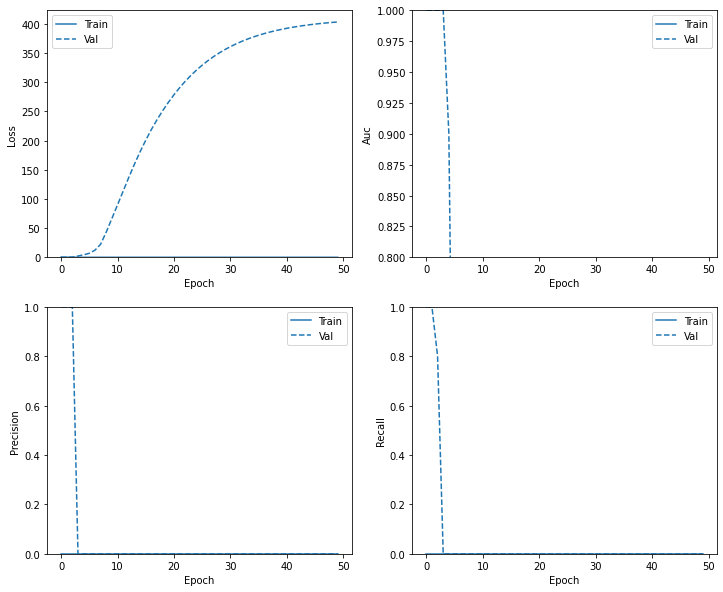

In [ ]:
plot_metrics(EURO_fit_history)

#### Compare with CEPR

In [ ]:
#BR_dataset_copy = BR_log_1df
#yBR = BR_dataset_copy.pop('CODACE')
#xBR = BR_dataset_copy

In [ ]:
#xBR = scaler.fit_transform(xBR)

Adjust dimb because of LSTM

In [ ]:
#xBR = np.expand_dims(xBR, 1)

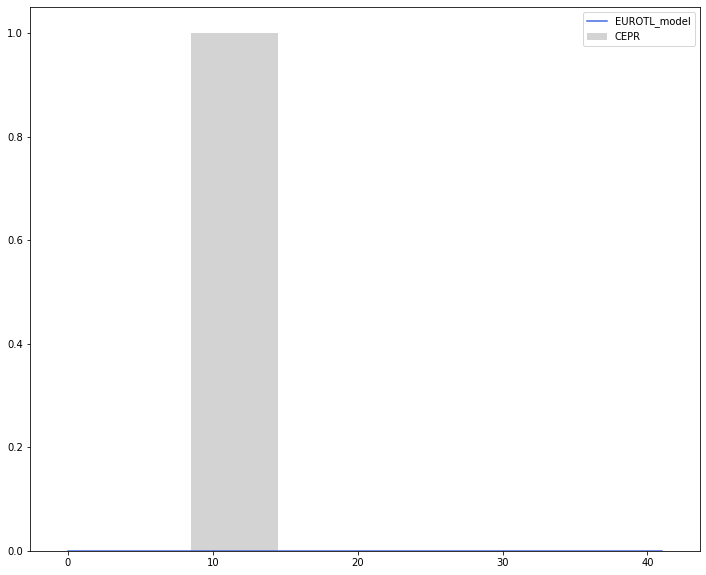

In [ ]:
BRTL_model = model.predict(EURO_test_features) 
time_axis = range(0,EURO_test_labels.shape[0])
plt.bar(time_axis, EURO_test_labels.T, width=1, linewidth=1, align='center', color="lightgray", label='CEPR') 
plt.plot(time_axis, BRTL_model, 'b-', color="royalblue", label='EUROTL_model')
plt.legend()
plt.show()

#### Confusion matrix

loss :  [0.]
tp :  [0.]
fp :  [0.]
tn :  [0.]
fn :  [0.]
accuracy :  [0.]
precision :  [0.]
recall :  [0.]
auc :  [0.]

Expansions Detected (True Negatives):  36
Expansions Incorrectly Detected (False Positives):  0
Recessions Missed (False Negatives):  6
Recessions Detected (True Positives):  0
Total Recessions:  6


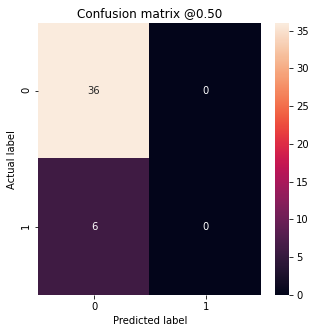

In [ ]:
BR_baseline_results = BRTL_model
for name, value in zip(model.metrics_names, BR_baseline_results):
  print(name, ': ', value)
print()

plot_cm(EURO_test_labels, BR_baseline_results)